In [1]:
from ultralytics import YOLO
import cv2
from ultralytics.utils.plotting import Annotator
import math
from PIL import Image
from src.aruco_marker import ArucoMarker
from src import config

In [2]:
model = YOLO(config.YOLO_BASE_MODEL)
names = model.model.names

In [3]:
img = cv2.imread('./../datasets/images/distance_detection/11.jpeg')

In [4]:
marker = ArucoMarker(config.MARKER_ARUCO_DICT, img, config.MARKER_PERIMETER_IN_CM)

In [5]:
print("ArUco Perimeter: {}".format(marker.get_perimeter()))
print("Pixels per centimeter: {}".format(marker.get_pixels_per_centimeter()))

print("Width in px: {}".format(marker.get_width()))
print("Width in cm: {}".format(marker.get_width_in_cm()))
print("Height in px: {}".format(marker.get_height()))
print("Height in cm: {}".format(marker.get_height_in_cm()))

ArUco Perimeter: 1816.6629333496094
Pixels per centimeter: 64.88081904820034
Width in px: 457.1575220862061
Width in cm: 7.04611206813806
Height in px: 455.2471856036015
Height in cm: 7.01666828936601


In [6]:
marker.draw_bounding_box(img, config.MARKER_BBOX_COLOR, config.LINE_WIDTH)

In [7]:
annotator = Annotator(img, line_width=config.LINE_WIDTH)

In [8]:
results = model.track(img, persist=True, device=config.YOLO_DEVICE)

0: 640x480 1 cell phone, 707.7ms
Speed: 2.8ms preprocess, 707.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
marker_center_point = marker.get_center()

if results[0].boxes.id is not None:
    boxes = results[0].boxes.xyxy.cpu()
    track_ids = results[0].boxes.id.int().cpu().tolist()

    for box, track_id in zip(boxes, track_ids):
        annotator.box_label(box, label=str(track_id), color=config.BBOX_COLOR)
        annotator.visioneye(box, marker_center_point)

        x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)    # Bounding box centroid

        distance = (math.sqrt((x1 - marker_center_point[0]) ** 2 + (y1 - marker_center_point[1]) ** 2))/marker.get_pixel_per_meter()
        distance_per_centimeter = distance * 100

        text_size, _ = cv2.getTextSize(f"Distance: {distance_per_centimeter:.2f} cm", cv2.FONT_HERSHEY_SIMPLEX,1.2, 3)
        cv2.rectangle(img, (x1, y1 - text_size[1] - 10),(x1 + text_size[0] + 10, y1), config.TXT_BG_COLOR, -1)
        cv2.putText(img, f"Distance: {distance_per_centimeter:.2f} cm",(x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2,config.TXT_COLOR, 3)

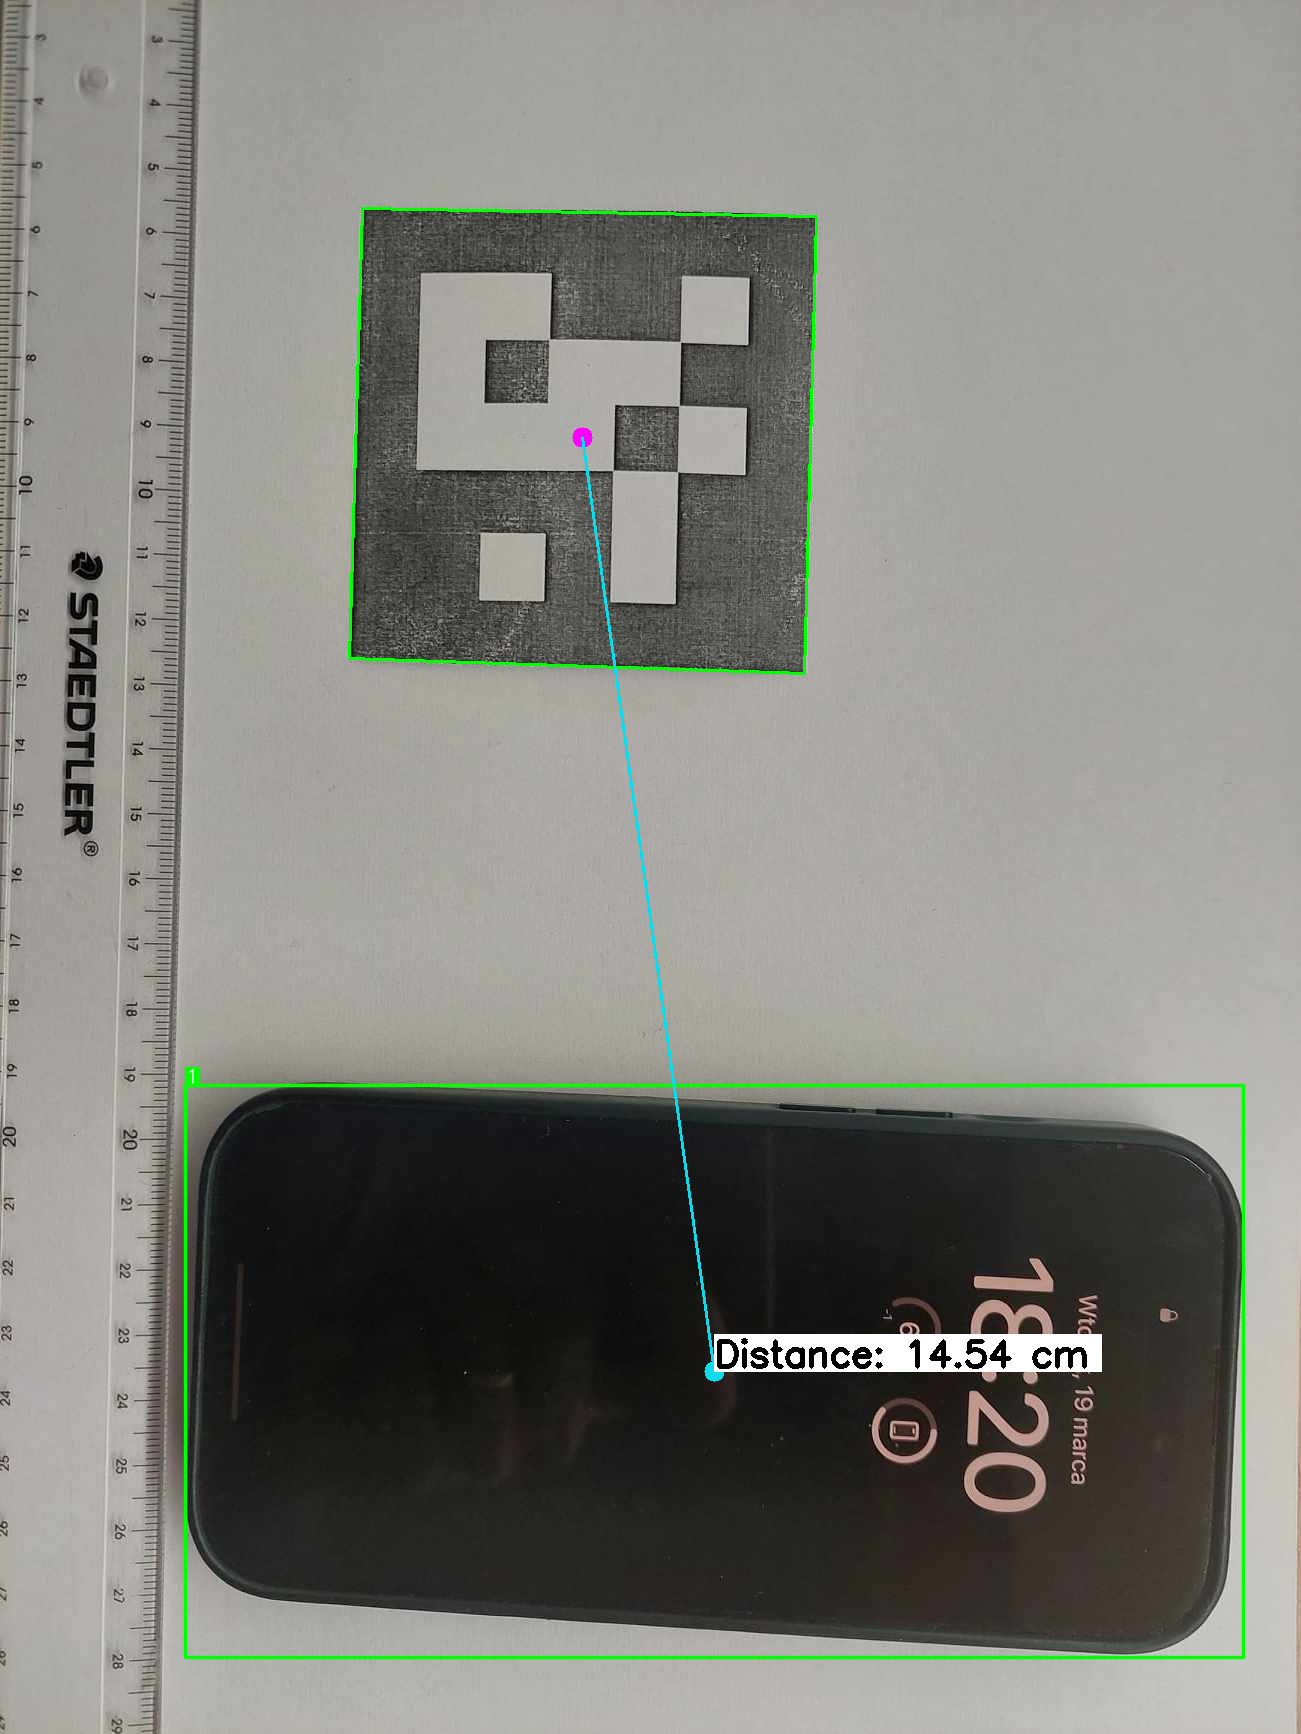

In [10]:
preview = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
display(Image.fromarray(preview))